In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import numpy as np
from torch.utils.data import DataLoader, Subset
import os
import random
from src.helper_functions import train_step, test_step, accuracy_fn

In [2]:
# Define the CNN backbone
class CNNFewShot(nn.Module):
    def __init__(self, num_classes=10):
        super(CNNFewShot, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [6]:
# Load CINIC-10 dataset
def load_cinic10(data_root, split='train', few_shot_per_class=10, batch_size=16):
    data_dir = os.path.join(data_root, "cinic-10", split)

    transform = transforms.Compose([
        transforms.Resize((32, 32)),  # Ensure images are 32x32
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    
    dataset = datasets.ImageFolder(root=data_dir, transform=transform)
    
    # Few-shot sampling
    class_indices = {label: [] for label in range(10)}
    for idx, (_, label) in enumerate(dataset.samples):
        class_indices[label].append(idx)

    few_shot_indices = []
    for indices in class_indices.values():
        few_shot_indices.extend(random.sample(indices, min(len(indices), few_shot_per_class)))  # Handle cases where a class has fewer than few_shot_per_class images

    few_shot_dataset = Subset(dataset, few_shot_indices)
    dataloader = DataLoader(few_shot_dataset, batch_size=batch_size, shuffle=True)

    return dataloader

In [4]:
# Train the CNN on few-shot data
def train_few_shot(model, dataloader, epochs=10, lr=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}")

In [44]:
data_dir = "../data"
dataloader = load_cinic10(data_dir, few_shot_per_class=100)
model = CNNFewShot(num_classes=10)
train_few_shot(model, dataloader, epochs=30)

Epoch 1/30, Loss: 140.0301
Epoch 2/30, Loss: 130.5040
Epoch 3/30, Loss: 122.4921
Epoch 4/30, Loss: 117.6616
Epoch 5/30, Loss: 113.4689
Epoch 6/30, Loss: 108.7996
Epoch 7/30, Loss: 105.2231
Epoch 8/30, Loss: 99.7009
Epoch 9/30, Loss: 95.1422
Epoch 10/30, Loss: 91.6946
Epoch 11/30, Loss: 87.1932
Epoch 12/30, Loss: 79.5073
Epoch 13/30, Loss: 73.5446
Epoch 14/30, Loss: 66.9699
Epoch 15/30, Loss: 56.9893
Epoch 16/30, Loss: 55.6412
Epoch 17/30, Loss: 47.6377
Epoch 18/30, Loss: 41.9103
Epoch 19/30, Loss: 35.5475
Epoch 20/30, Loss: 27.8572
Epoch 21/30, Loss: 23.9846
Epoch 22/30, Loss: 21.4306
Epoch 23/30, Loss: 19.3271
Epoch 24/30, Loss: 17.4580
Epoch 25/30, Loss: 17.2382
Epoch 26/30, Loss: 12.3468
Epoch 27/30, Loss: 13.3531
Epoch 28/30, Loss: 12.6478
Epoch 29/30, Loss: 10.8843
Epoch 30/30, Loss: 7.5393


In [39]:
from PIL import Image

def predict_image(model, image_path, class_names, device='cuda' if torch.cuda.is_available() else 'cpu'):
    transform = transforms.Compose([
        transforms.Resize((32, 32)),  # Ensure size matches training input
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    
    image = Image.open(image_path).convert("RGB")  # Ensure it's in RGB mode
    image = transform(image).unsqueeze(0)  # Add batch dimension

    model.to(device)
    model.eval()
    
    with torch.no_grad():
        image = image.to(device)
        output = model(image)
        probabilities = F.softmax(output, dim=1)  # Convert to probabilities
        predicted_class = torch.argmax(probabilities, dim=1).item()

    return class_names[predicted_class]

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']

image_path = "../data/cinic-10/train/deer/cifar10-train-343.png"
predicted_label = predict_image(model, image_path, class_names)
print(f"Predicted class: {predicted_label}")


Predicted class: deer


In [45]:
def calculate_accuracy(model, data_root, split='test', batch_size=32):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    test_loader = load_cinic10(data_root, split=split, few_shot_per_class=1000, batch_size=batch_size)  # Use a larger subset

    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)  # Get the class with highest probability
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = (correct / total) * 100
    print(f"Accuracy on {split} set: {accuracy:.2f}%")
    return accuracy

# Example usage:
data_root = "../data"
test_accuracy = calculate_accuracy(model, data_root, split='test')


Accuracy on test set: 35.78%


In [41]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(model, data_root, split='test', batch_size=32, class_names=None):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    test_loader = load_cinic10(data_root, split=split, few_shot_per_class=1000, batch_size=batch_size)

    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix on {split} set")
    plt.show()

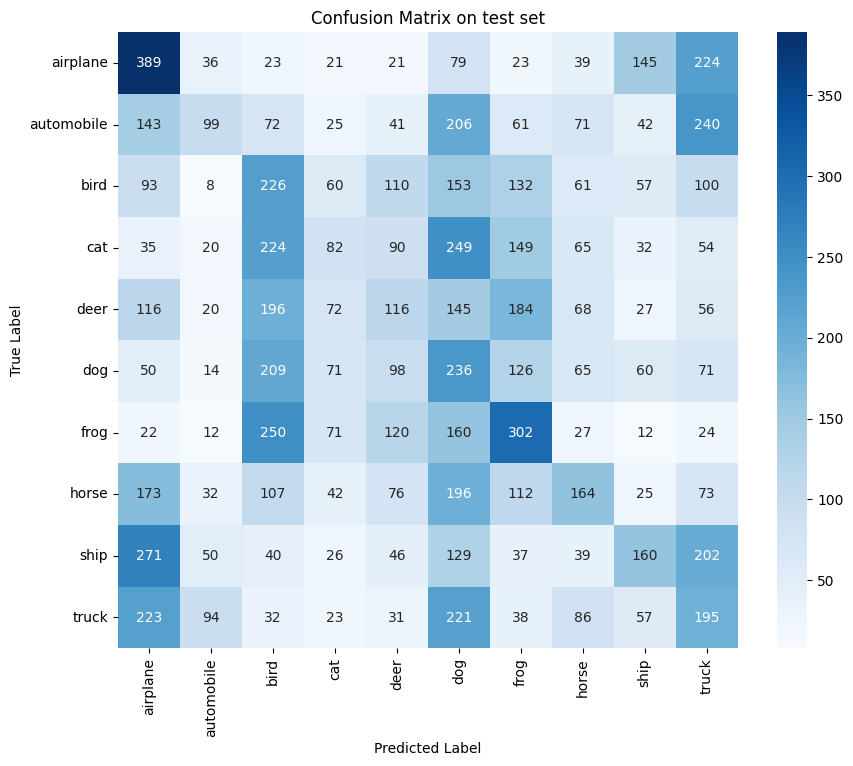

In [37]:
plot_confusion_matrix(model, data_root, split='test', class_names=class_names)